In [1]:
# It is important to have the same version in Kaggle and in local
# to save and import the models properly
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 69.0 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import re
import string
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
from functools import partial

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.5.2.


In [4]:
df = pd.read_csv("/kaggle/input/dataset-large.csv", na_filter=False)
df

,label,status_code,content_type,url,size,title,text
0,error,404,text/html,http://1ut8p3.com/product/aecphronian1201383?i...,1516,Domain misconfigured,Domain misconfigured\tThis domain points to Sh...
1,error,410,text/html,http://aka.justice.gov.uk/news/newsrelease0502...,2069,410 - Page Archived,410 - Page Archived\tMinistry of Justice\tThis...
2,error,404,text/html,http://aqwwiki.wikidot.com/paladin-ascendant-0-ac,25525,AQW,AQW\tHomepage\tNew Releases\tEncyclopedia\t+ W...
3,error,404,text/html,http://artikel-nolimitcity.online/3942972.phtml,48211,Page Not Found - Artikel Nolimit City,Page Not Found - Artikel Nolimit City\tSkip to...
4,error,406,text/html,http://bandongunclub.org/,251,406 Not Acceptable,406 Not Acceptable\tNot Acceptable\tAn appropr...
...,...,...,...,...,...,...,...
82488,content,200,text/html,https://www.applefritter.com/taxonomy/term/167...,48381,1994 | Applefritter,1994 | Applefritter\tSkip to main content\t199...
82489,content,200,text/html,https://www.aprosite.com/work/mobile-auto-mech...,76055,Mobile Auto Mechanics - Aprosite,"Mobile Auto Mechanics - Aprosite\t© Aprosite, ..."
82490,content,200,text/html,https://www.aquabion-uk.com/blog/,56130,Blog - Aquabion,Blog - Aquabion\tBlog\tWelcome to the AquaBion...
82491,content,200,text/html,https://www.arabicmusiclibrary.com/product/ana...,76018,Arabic Music Library - Ana A’m Behlam-(أنا عم ...,Arabic Music Library - Ana A’m Behlam-(أنا عم ...


In [5]:
text_stream = [nltk.word_tokenize(d.lower()) for d in df.text.tolist()]

In [6]:
!unzip -n /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [7]:
def token_is_error_status_code(token):
    try:
        n = int(token)
        return 400 <= n <= 425 or 500 <= n <= 511
    except ValueError:
        return False

def token_is_punctuation(token):
    for c in token:
        if c not in string.punctuation:
            return False
    return True

def is_token_just_word(token):
    return re.match("^[a-z'_]+$", token)

def clean_term_sentence(ts):
    for token in ts:
        token = token.strip()
        token = token.replace("’", "'")
        if token and not token_is_punctuation(token) \
            and (is_token_just_word(token) or token_is_error_status_code(token)): # and not is_token_stop_word(token) # not token_is_number(token):
            yield WordNetLemmatizer().lemmatize(token)

clean_streams = [list(clean_term_sentence(ts)) for ts in text_stream]

In [8]:
documents = [" ".join(ts) for ts in clean_streams]
# print(documents[:10])

In [9]:
my_vectorizer = TfidfVectorizer(
    analyzer='word', 
    max_features=30000,
    ngram_range=(1, 3)
)

X = my_vectorizer.fit_transform(documents)

doc_vectors = X.toarray()

In [10]:
X_train, X_test, y_train, y_test  = train_test_split(
        doc_vectors, 
        df["label"].tolist(),
        train_size=0.80,
        random_state=1234)

In [11]:
def show_metrics(model, y_true, y_pred):
    print("Model", model)
    print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
    print("Precision: {}".format(precision_score(y_true, y_pred, pos_label="error")))
    print("Recall: {}".format(recall_score(y_true, y_pred, pos_label="error")))
    print("F1: {}".format(f1_score(y_true, y_pred, pos_label="error")))
    
    labels = ['error', 'content']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    sns.heatmap(cm, 
                annot=True,
                fmt='g', 
                xticklabels=labels,
                yticklabels=labels)
    plt.ylabel('Actual', fontsize=13)
    plt.title('{} Confusion Matrix'.format(model), fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top') 
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()
    
    # plt.gca().figure.subplots_adjust(bottom=0.2)
    # plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
    plt.show()

In [12]:
svc_classifier = LinearSVC()
svc_model = svc_classifier.fit(X=X_train, y=y_train)
svc_y_pred = svc_model.predict(X_test)

Model LinearSVC
Accuracy: 0.9835747621067944
Precision: 0.9932211596659
Recall: 0.9744655581947743
F1: 0.9837539715844373


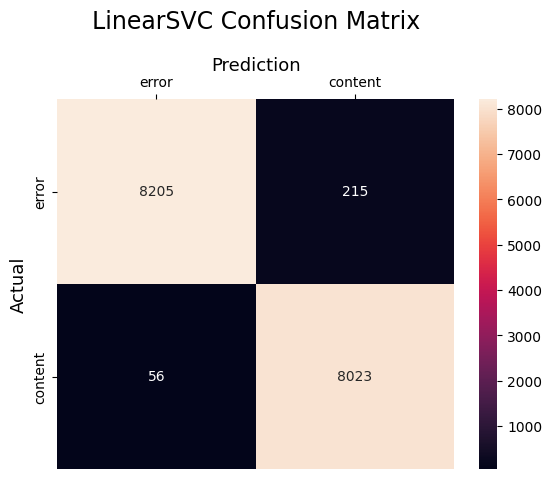

In [13]:
show_metrics("LinearSVC", y_test, svc_y_pred)

In [14]:
import pickle
from IPython.display import FileLink

def save_object_as_pickle(obj, filename):
    with open(filename, "wb") as fo:
        pickle.dump(obj, fo)

In [15]:
from datetime import datetime

date_part = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

In [16]:
filename = "tfidf-{}.pickle".format(date_part)
obj = my_vectorizer

save_object_as_pickle(obj, filename)
FileLink(filename)

/kaggle/working/tfidf-2024-12-29-01-55-08.pickle

In [17]:
filename = "svc-{}.pickle".format(date_part)
obj = svc_model

save_object_as_pickle(obj, filename)
FileLink(filename)

/kaggle/working/svc-2024-12-29-01-55-08.pickle

In [21]:
def preprocess_test_dataset(csv_dataset, vectorizer):
    df = pd.read_csv(csv_dataset)
    # df["tag"] = df.status_code.map(lambda c: "error" if c != 200 else "content" )
    
    # Tokenize and clean tokens to generate the documents
    text_stream = [nltk.word_tokenize(d.lower()) for d in df.text.tolist()]
    
    clean_streams = [list(clean_term_sentence(ts)) for ts in text_stream]

    documents = [" ".join(ts) for ts in clean_streams]


    doc_vectors = vectorizer.transform(documents).toarray()
    labels = df["label"].tolist()

    return doc_vectors, labels

In [22]:
X_real, y_real = preprocess_test_dataset("/kaggle/input/dataset-test.csv", my_vectorizer) 

In [23]:
X_real

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Model LinearSVC
Accuracy: 0.8585365853658536
Precision: 1.0
Recall: 0.7339449541284404
F1: 0.8465608465608465


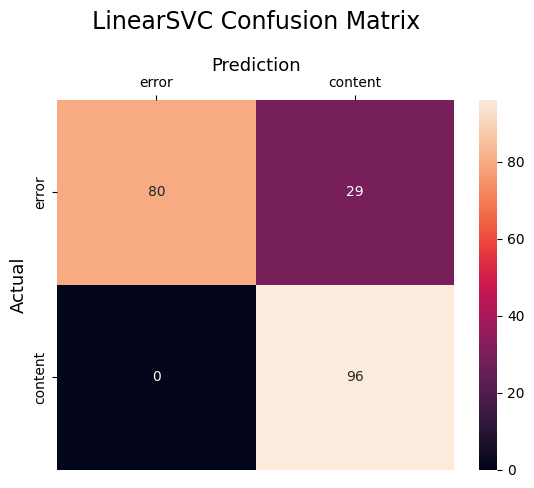

In [24]:
svc_y_real_pred = svc_model.predict(X_real)
show_metrics("LinearSVC", y_real, svc_y_real_pred)

In [25]:
df_real = pd.read_csv("/kaggle/input/dataset-test.csv")
df_real["pred"] = svc_y_real_pred
df_real

,label,status_code,content_type,url,size,title,text,pred
0,content,200,text/html,https://1000uglypeople.com/e7aef43b-edde-490a-...,0,NaN,Loading...,content
1,content,200,text/html,https://500px.com/e7aef43b-edde-490a-a95f-a31d...,0,NaN,500px\tYou need to enable JavaScript to run th...,content
2,content,200,text/html,https://35awards.com/e7aef43b-edde-490a-a95f-a...,0,NaN,Annual photography contest 10th 35AWARDS - 100...,content
3,error,200,text/html,http://12121.hostinguk.com/e7aef43b-edde-490a-...,0,NaN,404 Error - Customer Page Not Found | Hosting UK,error
4,error,200,text/html,https://aaft.com/e7aef43b-edde-490a-a95f-a31d9...,0,NaN,html\tError! 404\tError! 404\tContact\tUs,error
...,...,...,...,...,...,...,...,...
200,error,200,text/html,https://theboreds.com/e7aef43b-edde-490a-a95f-...,0,NaN,Coming Soon\ttheboreds.com,error
201,error,200,text/html,https://www.theninja-rpg.com/e7aef43b-edde-490...,0,NaN,TheNinja-RPG.com - a free browser based mmorpg...,error
202,error,200,application/octet-stream,https://themarshallplan.net/e7aef43b-edde-490a...,0,NaN,themarshallplan.net\tthemarshallplan.net\tComi...,error
203,error,200,text/html,http://www.thespamletters.com/e7aef43b-edde-49...,0,NaN,Web Page Under Construction\tThis Site Is Unde...,error


In [26]:
df_diff = df_real.query("tag != pred")
len(df_diff)

UndefinedVariableError: name 'tag' is not defined

In [27]:
for index, row in df_diff.iterrows():
    print("Status code:", row["status_code"])
    print("Tag:", row["tag"])
    print("Predicted:", row["pred"])
    print("Content_type:", row["content_type"])
    print("URL:", row["url"])
    print("Text:\n{}".format(row["text"]))
    print("\n========================================\n")

NameError: name 'df_diff' is not defined

In [ ]:
df_diff